In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as Scheduler
import torchvision.transforms as transforms
import sys

In [7]:
# Basic neural net block - 2 3x3 convs with batch normalization and ReLU and then maxpool
class Basic(nn.Module):
    def __init__(self, indepth, outdepth, stride=1, padding=1):
        super(Basic, self).__init__()
        
        self.conv1 = nn.Conv2d(indepth, outdepth, kernel_size=3, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(outdepth)
        self.conv2 = nn.Conv2d(outdepth, outdepth, kernel_size=3, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(outdepth)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2, stride=2)
        return out
    
class BasicNet(nn.Module):
    def __init__(self, block=Basic, blocks=[1,1,1], strides=[1,1,1], imagedepth=3, startoutputdepth=64, classnums=10):
        super(BasicNet, self).__init__()
        self.imagedepth = imagedepth
        self.outdepth = startoutputdepth
        layers = []
        for i in range(len(blocks)):
            layer = block(self.imagedepth, self.outdepth, strides[i])
            layers.append(layer)
            self.imagedepth = self.outdepth
            self.outdepth = self.outdepth*2
        self.outdepth /= 2 #undoing last multiplication
        self.alllayers = nn.Sequential(*layers)
        self.linearlayer = nn.Sequential(nn.Linear(4096, classnums),
                                         nn.Softmax())
    def forward(self, x):
        out = self.alllayers(x)
        out = out.view(-1, 4096)
        #print(out.size()[1]*out.size()[2]*out.size()[3])
        out = self.linearlayer(out)
        return out

In [8]:
class DataReading():
    def __init__(self):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                                download=True, transform=transform)
        valset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                                download=True, transform=transform)
        trainSampler, valSampler = self.validationSplit(trainset)
        self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, sampler=trainSampler, num_workers=2)
        self.valloader = torch.utils.data.DataLoader(valset, batch_size=256, sampler=valSampler, num_workers=2)
        testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                               download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                                 shuffle=False, num_workers=2)

        self.classes = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    def validationSplit(self, trainset, ratio=0.1, random_seed=42):
        trainlen = len(trainset)
        indices = list(range(trainlen))
        split = int(np.floor(ratio*trainlen))
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)    
        return train_sampler, valid_sampler

In [20]:
class ModelTrainer():
    def __init__(self, optimizer, errorfn, model):
        self.net = model
        self.net.cuda()
        if(optimizer==optim.Adam):
            self.optimizer = optimizer(self.net.parameters())
        elif(optimizer==optim.SGD):
            self.optimizer = optimizer(self.net.parameters(), lr=0.01)
        self.scheduler = Scheduler.ReduceLROnPlateau(self.optimizer, patience=2, verbose=True)
        self.criterion = errorfn
        self.data = DataReading()
        
    def train(self):
        testLoss = []
        valLoss = []
        trainLoss = []
        testAcc = []
        valAcc = []
        trainAcc = []
        prevValLoss = sys.maxsize
        stopCount = 0
        stopEpochs = False
        for epoch in range(350):  # loop over the dataset multiple times
            running_loss = 0.0
            runcount = 0
            val_loss = 0.0
            valcount = 0
            test_loss = 0.0
            testcount = 0
            correct = 0
            total = 0
            for i, data in enumerate(self.data.trainloader, 0):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.data[0]
                runcount += 1

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cuda() == labels.data).sum()
        #     if(epoch%10==0):
            print('[%d] training loss: %.3f' %
                          (epoch + 1, running_loss / runcount))
            print('[%d] training accuracy: %.3f' %
                          (epoch + 1, 100 * correct / total))
            trainLoss.append(running_loss / runcount)
            trainAcc.append(100 * correct / total)
            correct = 0
            total = 0

            for i, data in enumerate(self.data.valloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.data[0]
                valcount += 1
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cuda() == labels.data).sum()
            valloss = val_loss/valcount
            self.scheduler.step(valloss)
            if(epoch>10 and prevValLoss<=valloss):
                stopCount += 1
                if(stopCount>3):
                    stopEpochs = True
            else:
                stopCount = 0
            prevValLoss = valloss
        #     if(epoch%10==0):
            print('[%d] validation loss: %.3f' %
                          (epoch + 1, valloss))
            print('[%d] validation accuracy: %.3f' %
                          (epoch + 1, 100 * correct / total))
            valLoss.append(valloss)
            valAcc.append(100 * correct / total)
            correct = 0
            total = 0

            for i, data in enumerate(self.data.testloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.data[0]
                testcount += 1
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cuda() == labels.data).sum()

        #     if(epoch%10==0):
            print('[%d] test loss: %.3f' %
                          (epoch + 1, test_loss / testcount))
            print('[%d] test accuracy: %.3f' %
                          (epoch + 1, 100 * correct / total))
            testLoss.append(test_loss / testcount)
            testAcc.append(100 * correct / total)
            if(stopEpochs):
                break

        print('Finished Training')

        plt.title("Basic conv Net - 3 Layers")
        plt.plot(trainLoss, label="Train", color='blue')
        plt.plot(valLoss, label="Validation", color='green')
        plt.plot(testLoss, label="Test", color='red')
        plt.ylabel("Loss")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()

        plt.title("Basic conv net - 3 Layers")
        plt.plot(trainAcc, label="Train", color='blue')
        plt.plot(valAcc, label="Validation", color='green')
        plt.plot(testAcc, label="Test", color='red')
        plt.ylabel("Accuracy")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()

In [13]:
model = ModelTrainer(optim.Adam, nn.CrossEntropyLoss(), BasicNet())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


[1] training loss: 1.996
[1] training accuracy: 46.564
[1] validation loss: 1.911
[1] validation accuracy: 55.400
[1] test loss: 1.904
[1] test accuracy: 55.720
[2] training loss: 1.875
[2] training accuracy: 58.736
[2] validation loss: 1.842
[2] validation accuracy: 62.100
[2] test loss: 1.843
[2] test accuracy: 61.720
[3] training loss: 1.808
[3] training accuracy: 65.527
[3] validation loss: 1.810
[3] validation accuracy: 65.140
[3] test loss: 1.815
[3] test accuracy: 64.460
[4] training loss: 1.775
[4] training accuracy: 68.716
[4] validation loss: 1.776
[4] validation accuracy: 68.680
[4] test loss: 1.774
[4] test accuracy: 68.640
[5] training loss: 1.749
[5] training accuracy: 71.504
[5] validation loss: 1.760
[5] validation accuracy: 70.160
[5] test loss: 1.760
[5] test accuracy: 69.820
[6] training loss: 1.729
[6] training accuracy: 73.311
[6] validation loss: 1.754
[6] validation accuracy: 71.200
[6] test loss: 1.751
[6] test accuracy: 71.120
[7] training loss: 1.710
[7] train

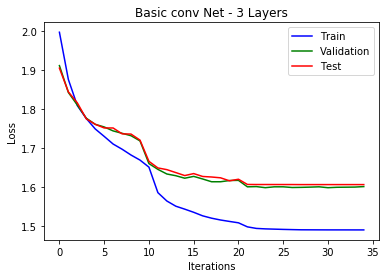

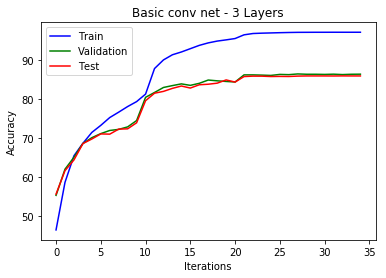

In [14]:
model.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[1] training loss: 2.221
[1] training accuracy: 26.536
[1] validation loss: 2.147
[1] validation accuracy: 35.660
[1] test loss: 2.139
[1] test accuracy: 37.030
[2] training loss: 2.094
[2] training accuracy: 40.451
[2] validation loss: 2.065
[2] validation accuracy: 43.300
[2] test loss: 2.056
[2] test accuracy: 44.420
[3] training loss: 2.027
[3] training accuracy: 47.060
[3] validation loss: 2.012
[3] validation accuracy: 47.980
[3] test loss: 2.006
[3] test accuracy: 48.730
[4] training loss: 1.982
[4] training accuracy: 51.076
[4] validation loss: 1.978
[4] validation accuracy: 51.000
[4] test loss: 1.972
[4] test accuracy: 52.050
[5] training loss: 1.951
[5] training accuracy: 53.858
[5] validation loss: 1.950
[5] validation accuracy: 53.680
[5] test loss: 1.948
[5] test accuracy: 54.610
[6] training loss: 1.925
[6] training accuracy: 56.304
[6] validation loss: 1.929

[49] validation loss: 1.697
[49] validation accuracy: 77.540
[49] test loss: 1.698
[49] test accuracy: 77.780
[50] training loss: 1.557
[50] training accuracy: 92.184
Epoch    49: reducing learning rate of group 0 to 1.0000e-04.
[50] validation loss: 1.696
[50] validation accuracy: 77.680
[50] test loss: 1.698
[50] test accuracy: 77.820
[51] training loss: 1.556
[51] training accuracy: 92.258
[51] validation loss: 1.696
[51] validation accuracy: 77.540
[51] test loss: 1.698
[51] test accuracy: 77.810
[52] training loss: 1.556
[52] training accuracy: 92.316
[52] validation loss: 1.695
[52] validation accuracy: 77.840
[52] test loss: 1.698
[52] test accuracy: 77.790
[53] training loss: 1.556
[53] training accuracy: 92.298
Epoch    52: reducing learning rate of group 0 to 1.0000e-05.
[53] validation loss: 1.696
[53] validation accuracy: 77.900
[53] test loss: 1.698
[53] test accuracy: 77.780
[54] training loss: 1.556
[54] training accuracy: 92.316
[54] validation loss: 1.695
[54] validati

[96] test loss: 1.698
[96] test accuracy: 77.770
[97] training loss: 1.555
[97] training accuracy: 92.298
[97] validation loss: 1.696
[97] validation accuracy: 77.780
[97] test loss: 1.698
[97] test accuracy: 77.770
[98] training loss: 1.556
[98] training accuracy: 92.340
[98] validation loss: 1.695
[98] validation accuracy: 77.900
[98] test loss: 1.698
[98] test accuracy: 77.770
[99] training loss: 1.555
[99] training accuracy: 92.282
[99] validation loss: 1.696
[99] validation accuracy: 78.020
[99] test loss: 1.698
[99] test accuracy: 77.770
[100] training loss: 1.555
[100] training accuracy: 92.327
[100] validation loss: 1.694
[100] validation accuracy: 78.120
[100] test loss: 1.698
[100] test accuracy: 77.770
[101] training loss: 1.556
[101] training accuracy: 92.300
[101] validation loss: 1.694
[101] validation accuracy: 78.100
[101] test loss: 1.698
[101] test accuracy: 77.770
[102] training loss: 1.556
[102] training accuracy: 92.289
[102] validation loss: 1.694
[102] validation

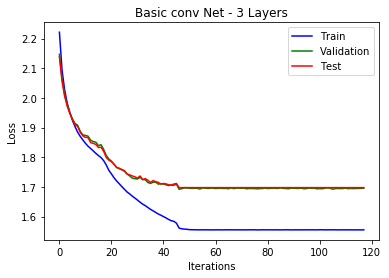

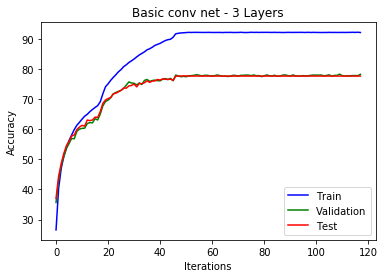

In [21]:
model = ModelTrainer(optim.SGD, nn.CrossEntropyLoss(), BasicNet())
model.train()